<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Logistic Regression

In [6]:
# Import the libraries we know we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap

from logreg_model import sigmoid,NLL_batch_gradient_descent

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'logreg_model'

We are going to use a dataset from the University of Wisconsin which contains features of the cell nuclei present in biopsies of breast masses.  The target to predict is whether the mass is malignant or benign.  Description of the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [2]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X.head()

In [3]:
# Check the number of benign vs malignant to make sure we do not have strong class imbalance
# Now 0=benign and 1=malignant
y.value_counts()

0    357
1    212
Name: target, dtype: int64

In [4]:
# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale the inputs to help it converge more easily
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic regression using batch gradient descent

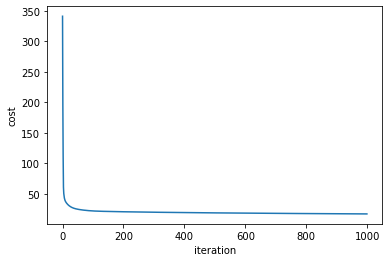

In [13]:
# Run gradient descent to get the weights that minimize our cost NLL
n_iterations = 1000
learning_rate = 0.01

# Initialize the weights to random numbers
rand_gen = np.random.RandomState(1)
weights_init = rand_gen.normal(loc=0.0,scale=0.1,size=X_train.shape[1])

# Run logistic regression with gradient descent
weights_opt,cost_path = NLL_batch_gradient_descent(X_train_scaled,y_train,weights_init,
                                                       learning_rate,n_iterations)
plt.plot(range(n_iterations),cost_path)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

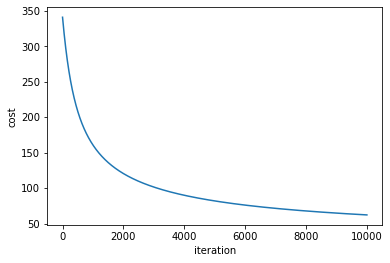

In [11]:
# Run again this time with a really small learning rate
n_iterations = 1000
learning_rate = 0.000001

# Initialize the weights to random numbers
rand_gen = np.random.RandomState(1)
weights_init = rand_gen.normal(loc=0.0,scale=0.1,size=X_train.shape[1])

weights,cost_path = NLL_batch_gradient_descent(X_train_scaled,y_train,weights_init,
                                                       learning_rate,n_iterations)

plt.plot(range(n_iterations),cost_path)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

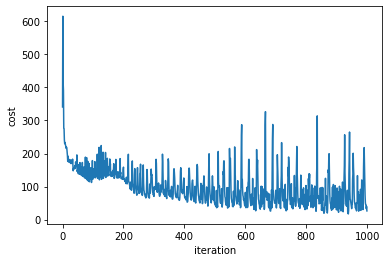

In [12]:
# Run again with a large learning rate
n_iterations = 1000
learning_rate = 0.8

# Initialize the weights to random numbers
rand_gen = np.random.RandomState(1)
weights_init = rand_gen.normal(loc=0.0,scale=0.1,size=X_train.shape[1])

weights,cost_path = NLL_batch_gradient_descent(X_train_scaled,y_train,weights_init,
                                                       learning_rate,n_iterations)

plt.plot(range(n_iterations),cost_path)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

In [9]:
# Use our model to generate predictions and calculate accuracy
test_preds_probs = sigmoid(X_test_scaled.dot(weights_opt))

# Convert predicted probabilities to class predictions
test_preds = np.round(test_preds_probs).astype(int)

acc_score = accuracy_score(y_test,test_preds)
print('Accuracy on test set is {:.3f}'.format(acc_score))

Accuracy on test set is 0.965


## Logistic regression using Scikit Learn

In [15]:
# Fit a logistic regression model using Scikit Learn.  Use no regularization penalty
model = LogisticRegression(penalty='none')
model.fit(X_train_scaled,y_train)
test_preds = model.predict(X_test_scaled)
acc_score = accuracy_score(y_test,test_preds)
print('Accuracy on test set is {:.3f}'.format(acc_score))

Accuracy on test set is 0.956


Let's run logistic regression again this time usuing L2 regularizaiton and optimizing the penalty factor using cross-validation

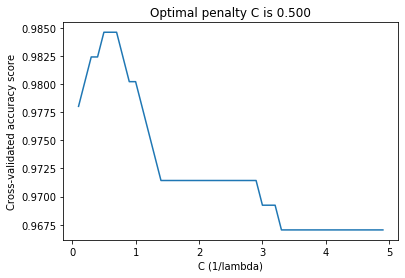

Accuracy on test set is 0.965


In [16]:
# Run again this time using L2 regularization
# Find optimal penalty factor using cross-validation
# Note that for logistic regression, the penalty factor is C which is 1/lambda

# Use cross-validation to find the optimal C
acc_scores = []
c_vals = np.arange(0.1,5,0.1)
for c in c_vals:
    model = LogisticRegression(penalty='l2',C=c)
    scores = cross_val_score(model,X_train_scaled,y_train,scoring='accuracy',cv=5)
    acc_scores.append(np.mean(scores))

plt.plot(c_vals,acc_scores)
opt_c = c_vals[np.argmax(acc_scores)]
plt.title('Optimal penalty C is {:.3f}'.format(opt_c))
plt.xlabel('C (1/lambda)')
plt.ylabel('Cross-validated accuracy score')
plt.show()


# Retrain the final model on the full training set and calculate the test set accuracy
final_model = LogisticRegression(penalty='l2',C=opt_c,random_state=0)
final_model.fit(X_train_scaled,y_train)
test_preds = final_model.predict(X_test_scaled)
acc_score = accuracy_score(y_test,test_preds)
print('Accuracy on test set is {:.3f}'.format(acc_score))

## Visualize the decision boundary

In [17]:
# Visualize the decision boundaries
def plot_decision_boundaries(X,y,model):
    markers = ['^','s','v','o','x']
    colors = ['yellow','green','purple','blue','orange']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    for i,k in enumerate(np.unique(y)):
        plt.scatter(X.loc[y==k].iloc[:,0],X.loc[y==k].iloc[:,1],
                    c=colors[i],marker=markers[i],label=k,edgecolor='black')

    xgrid = np.arange(X.iloc[:,0].min(),X.iloc[:,0].max(),
                      (X.iloc[:,0].max()-X.iloc[:,0].min())/500)
    ygrid = np.arange(X.iloc[:,1].min(),X.iloc[:,1].max(),
                      (X.iloc[:,1].max()-X.iloc[:,1].min())/500)
    xx,yy = np.meshgrid(xgrid,ygrid)
    mesh_preds = model.predict(np.c_[xx.ravel(),yy.ravel()])
    mesh_preds = mesh_preds.reshape(xx.shape)
    plt.contourf(xx,yy,mesh_preds,alpha=0.2,cmap=cmap)
    plt.legend()
    return

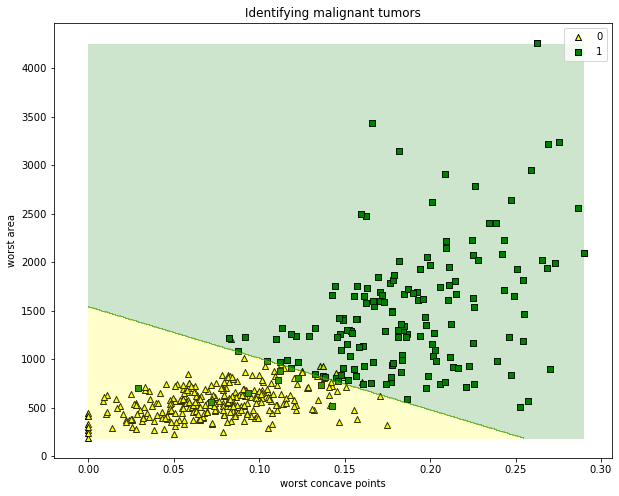

In [18]:
# Let's create a model using just two features so we can visualize it
X_train_2feats = X_train[['worst concave points','worst area']]
model_2feats = LogisticRegression(penalty='none')
model_2feats.fit(X_train_2feats,y_train)

plt.figure(figsize=(10,8))
plot_decision_boundaries(X_train_2feats,y_train,model_2feats)
plt.xlabel('worst concave points')
plt.ylabel('worst area')
plt.title('Identifying malignant tumors')
plt.show()

## Multiclass logistic regression (Softmax regression)

In [19]:
# Load the dataset using a helper function in Seaborn
iris = sns.load_dataset('iris')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [20]:
# What are the target classes?
pd.unique(iris['species'])

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [21]:
# Create feature matrix using just 2 features so we can visualize the decision boundaries
X = iris[['sepal_length','sepal_width']]

# Create target vector and convert to numeric codes (not required, but used for visualization)
y = iris['species']
y_numeric_dict={'setosa':1,'versicolor':2,'virginica':3}
y = y.apply(lambda x: y_numeric_dict[x])

# Split into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

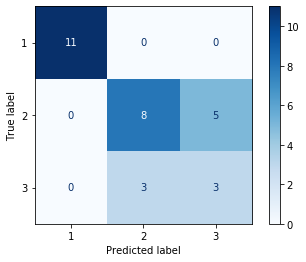

In [22]:
# Train a multi-class softmax regression model and get the test set predictions
model = LogisticRegression(penalty='l2',C=1.0)
model.fit(X_train,y_train)
test_preds = model.predict(X_test)

# Display the confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues,normalize=None)
plt.show()

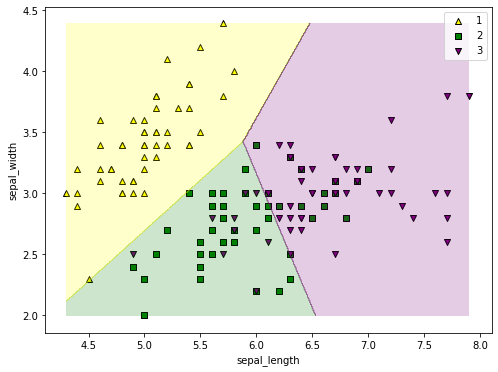

In [23]:
# Plot the decision boundary

plt.figure(figsize=(8,6))
plot_decision_boundaries(X,y,model)
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()